# pix2pix for Maps to Aerial Image Translation

In [7]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import pixutils as pxu
from pix2pix import UNet, PatchGAN, fit
import wandb
import os

In [8]:
wandb.login()

wandb: Currently logged in as: v-modroczky (nsiete23). Use `wandb login --relogin` to force relogin


True

In [9]:
train_path = "pix2pix-maps/train/*.jpg"
val_path = "pix2pix-maps/val/*.jpg"

buffer_size = 256
patch_size = 256
num_of_patches = (600//patch_size)**2

config = {
    "batch_size": 1,
    "lr_gen": 0.0002,
    "beta_1_gen": 0.5,
    "lr_disc": 0.0002,
    "beta_1_disc": 0.5,
    "l1_lambda": 100,
}

## Run the following code block on Kaggle only

In [10]:
train_path = f"/kaggle/input/{train_path}"
val_path = f"/kaggle/input/{val_path}"

## Load dataset

In [11]:
train = tf.data.Dataset.list_files(train_path)
val = tf.data.Dataset.list_files(val_path)

In [12]:
train = train.map(pxu.load_image)
train = train.map(lambda input_image, real_image: pxu.extract_patches(input_image, real_image, patch_size, num_of_patches))
# data are in batches of size 'num_of_patches' after 'extract_patches'
train = train.unbatch()
train = train.map(lambda input_patches, real_patches: pxu.random_jitter(input_patches, real_patches, 286))
train = train.map(pxu.rescale_images)
train = train.shuffle(buffer_size)
train = train.batch(config["batch_size"])

val = val.map(pxu.load_image)
val = val.map(lambda input_image, real_image: pxu.extract_patches(input_image, real_image, patch_size, num_of_patches))
# data are in batches of size 'num_of_patches' after 'extract_patches'
val = val.unbatch()
val = val.map(pxu.rescale_images)
val = val.batch(config["batch_size"])

## Visualize a few images

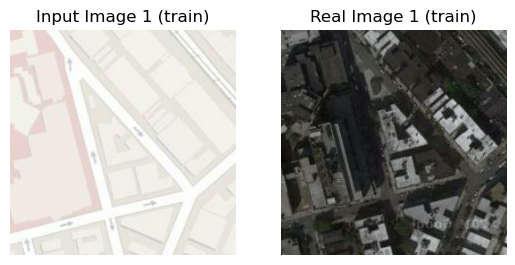

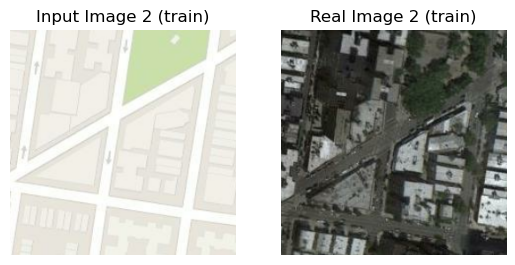

In [13]:
i = 0
for input_batch, real_batch in train.take(2):
    for input_batch, real_image in zip(input_batch, real_batch):
        i += 1
        pxu.show(
            input_batch,
            real_image,
            i,
            "train"
        )

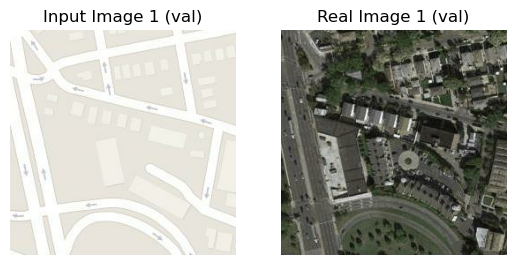

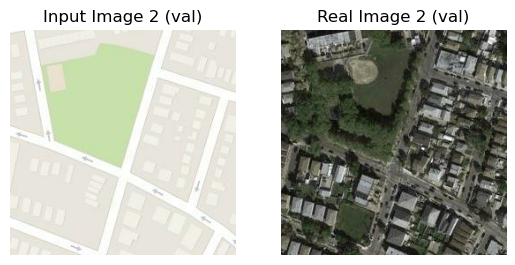

In [14]:
i = 0
for input_batch, real_batch in val.take(2):
    for input_batch, real_image in zip(input_batch, real_batch):
        i += 1
        pxu.show(
            input_batch,
            real_image,
            i,
            "val"
        )

## Create models

In [15]:
G = UNet(input_shape=(patch_size, patch_size, 3))
D = PatchGAN(input_shape=(patch_size, patch_size, 3))

config["epochs"] = 250

restore_last_epoch = 170
restore_run_id = "nsu3bcg1"

if restore_last_epoch is not None:
    config["epochs"] -= restore_last_epoch
    run_path = f"nsiete23/pix2pix/{restore_run_id}"
    gen_file = wandb.restore(f"checkpoints/generator_{restore_last_epoch}.h5", run_path=run_path)
    disc_file = wandb.restore(f"checkpoints/discriminator_{restore_last_epoch}.h5", run_path=run_path)
    G = load_model(gen_file.name)
    D = load_model(disc_file.name)
    print(
        "Resumed:",
        gen_file.name,
        disc_file.name,
        sep=os.linesep
    )

g_optim = Adam(learning_rate=config["lr_gen"], beta_1=config["beta_1_gen"])
d_optim = Adam(learning_rate=config["lr_disc"], beta_1=config["beta_1_disc"])

Resumed:
/kaggle/working/checkpoints/generator_170.h5
/kaggle/working/checkpoints/discriminator_170.h5


## Train

2023-04-28 18:59:57.108088: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_8/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch: 1, Step: 4383, Gen Loss: 11.183537483215332, Disc Loss: 0.462137460708618161


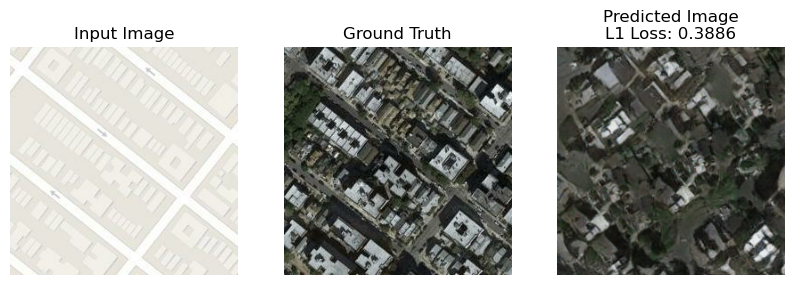

Epoch: 2, Step: 4383, Gen Loss: 22.34139060974121, Disc Loss: 0.01007348485291004256
Epoch: 3, Step: 4383, Gen Loss: 34.706298828125, Disc Loss: 0.24341037869453436232255
Epoch: 4, Step: 4383, Gen Loss: 17.299482345581055, Disc Loss: 0.6833217740058899753
Epoch: 5, Step: 4383, Gen Loss: 34.834129333496094, Disc Loss: 0.1766314059495926563
Epoch: 6, Step: 4383, Gen Loss: 28.656646728515625, Disc Loss: 0.2443861216306686445
Epoch: 7, Step: 4383, Gen Loss: 10.39221477508545, Disc Loss: 0.6450450420379639884
Epoch: 8, Step: 4383, Gen Loss: 28.458982467651367, Disc Loss: 0.1117446869611740135
Epoch: 9, Step: 4383, Gen Loss: 35.37918472290039, Disc Loss: 0.33920377492904663546
Epoch: 10, Step: 4383, Gen Loss: 26.765438079833984, Disc Loss: 0.1284307539463043275


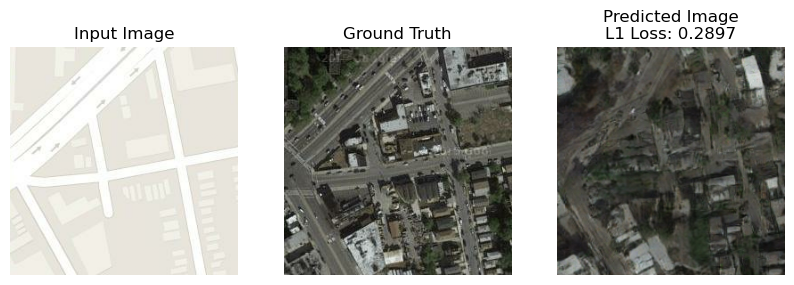

Epoch: 11, Step: 4383, Gen Loss: 20.09336280822754, Disc Loss: 0.5962802171707153886
Epoch: 12, Step: 4383, Gen Loss: 28.882986068725586, Disc Loss: 0.1753043234348297524
Epoch: 13, Step: 4383, Gen Loss: 39.207801818847656, Disc Loss: 0.1881096065044403426
Epoch: 14, Step: 4383, Gen Loss: 18.873247146606445, Disc Loss: 0.141008689999580383
Epoch: 15, Step: 4383, Gen Loss: 31.183664321899414, Disc Loss: 0.0696506053209304836
Epoch: 16, Step: 4383, Gen Loss: 22.843759536743164, Disc Loss: 0.500028371810913144
Epoch: 17, Step: 4383, Gen Loss: 24.9549617767334, Disc Loss: 0.072918809950351727865
Epoch: 18, Step: 4383, Gen Loss: 17.978199005126953, Disc Loss: 0.113723084330558785
Epoch: 19, Step: 4383, Gen Loss: 31.23920249938965, Disc Loss: 0.3329510390758514465
Epoch: 20, Step: 4383, Gen Loss: 29.351316452026367, Disc Loss: 0.202850878238677985


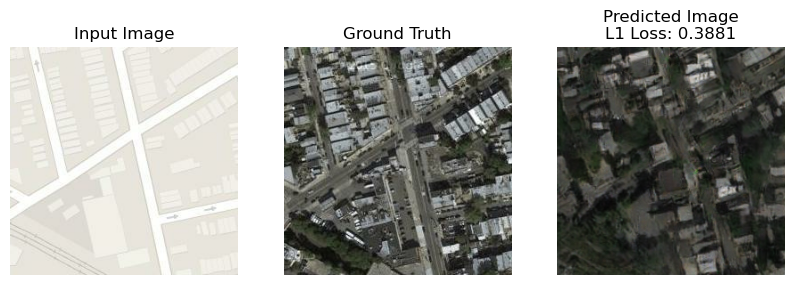

Epoch: 21, Step: 4383, Gen Loss: 29.534006118774414, Disc Loss: 0.1947855502367019745
Epoch: 22, Step: 4383, Gen Loss: 4.169775009155273, Disc Loss: 0.44646632671356216665
Epoch: 23, Step: 4383, Gen Loss: 28.194765090942383, Disc Loss: 0.709184229373931952
Epoch: 24, Step: 4383, Gen Loss: 31.2081298828125, Disc Loss: 0.662501394748687782536
Epoch: 25, Step: 4383, Gen Loss: 36.28216552734375, Disc Loss: 0.09764479100704193944
Epoch: 26, Step: 4383, Gen Loss: 30.00499725341797, Disc Loss: 0.03931303322315216465
Epoch: 27, Step: 4383, Gen Loss: 28.058076858520508, Disc Loss: 0.140416786074638377
Epoch: 28, Step: 4383, Gen Loss: 13.722026824951172, Disc Loss: 0.0251561254262924244
Epoch: 29, Step: 4383, Gen Loss: 19.819272994995117, Disc Loss: 0.2909958362579345764
Epoch: 30, Step: 4383, Gen Loss: 29.226856231689453, Disc Loss: 0.941275119781494156


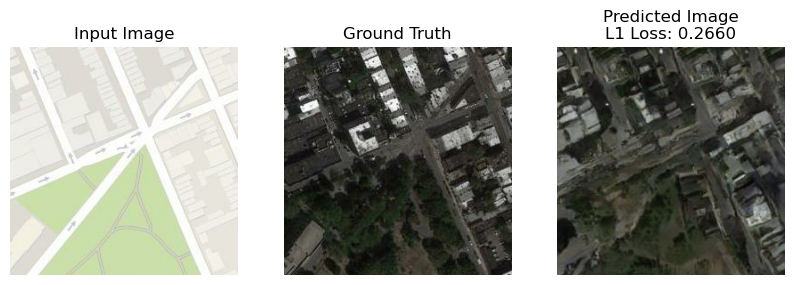

Epoch: 31, Step: 4383, Gen Loss: 7.876047134399414, Disc Loss: 0.73155713081359861796
Epoch: 32, Step: 4383, Gen Loss: 22.577880859375, Disc Loss: 0.5125713348388672138465
Epoch: 33, Step: 4383, Gen Loss: 33.17366027832031, Disc Loss: 0.05770460143685341565
Epoch: 34, Step: 4383, Gen Loss: 40.59149932861328, Disc Loss: 0.00665231607854366345
Epoch: 35, Step: 4383, Gen Loss: 16.095340728759766, Disc Loss: 0.1571245491504669262
Epoch: 36, Step: 4383, Gen Loss: 10.515935897827148, Disc Loss: 0.7269577980041504695
Epoch: 37, Step: 4383, Gen Loss: 28.556310653686523, Disc Loss: 0.2726835906505584785
Epoch: 38, Step: 4383, Gen Loss: 28.902626037597656, Disc Loss: 0.8865529894828796373
Epoch: 39, Step: 4383, Gen Loss: 27.203563690185547, Disc Loss: 0.9986164569854736457
Epoch: 40, Step: 4383, Gen Loss: 23.055862426757812, Disc Loss: 0.658152163028717443


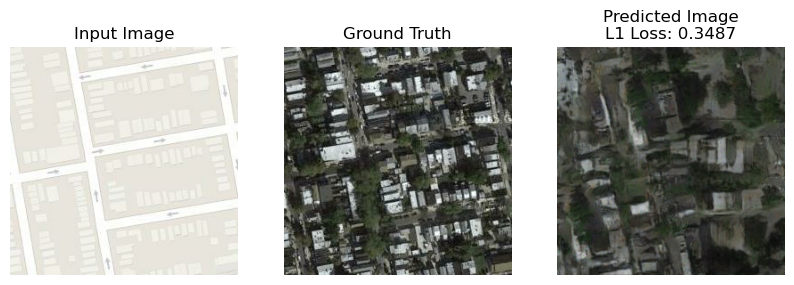

Epoch: 41, Step: 4383, Gen Loss: 5.814715385437012, Disc Loss: 0.12066001445055008365
Epoch: 42, Step: 4383, Gen Loss: 37.114044189453125, Disc Loss: 0.1093848496675491335
Epoch: 43, Step: 4383, Gen Loss: 18.534198760986328, Disc Loss: 0.9952392578125841156
Epoch: 44, Step: 4383, Gen Loss: 22.054668426513672, Disc Loss: 0.130673110485076935
Epoch: 45, Step: 4383, Gen Loss: 12.927875518798828, Disc Loss: 0.5221866965293884365
Epoch: 46, Step: 4383, Gen Loss: 21.769451141357422, Disc Loss: 0.6562631130218506385
Epoch: 47, Step: 4383, Gen Loss: 39.32415771484375, Disc Loss: 0.0400906316936016174
Epoch: 48, Step: 4383, Gen Loss: 37.888145446777344, Disc Loss: 0.1630434095859527665
Epoch: 49, Step: 4383, Gen Loss: 23.163589477539062, Disc Loss: 0.288795471191406256
Epoch: 50, Step: 4383, Gen Loss: 29.438323974609375, Disc Loss: 0.2066392600536346478


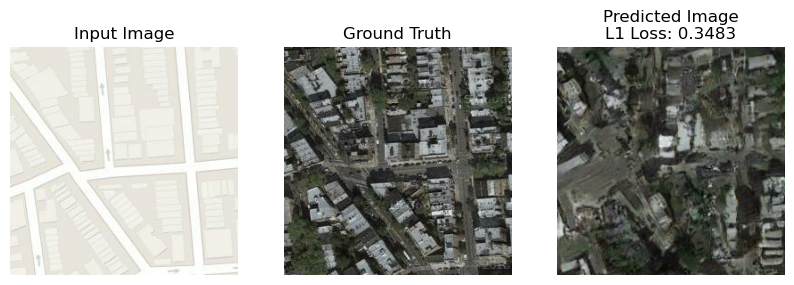

Epoch: 51, Step: 4383, Gen Loss: 39.873756408691406, Disc Loss: 0.063601821660995487
Epoch: 52, Step: 4383, Gen Loss: 22.76126480102539, Disc Loss: 0.23779885470867157885
Epoch: 53, Step: 4383, Gen Loss: 26.808568954467773, Disc Loss: 0.0696046128869056745
Epoch: 54, Step: 4383, Gen Loss: 27.329086303710938, Disc Loss: 0.389669626951217655
Epoch: 55, Step: 4383, Gen Loss: 33.001625061035156, Disc Loss: 0.0639570057392120464
Epoch: 56, Step: 4383, Gen Loss: 34.67137145996094, Disc Loss: 0.02234575711190700546
Epoch: 57, Step: 4383, Gen Loss: 33.19049835205078, Disc Loss: 0.18163305521011353957
Epoch: 58, Step: 4383, Gen Loss: 35.04225158691406, Disc Loss: 0.03999390080571174664
Epoch: 59, Step: 4383, Gen Loss: 25.77981185913086, Disc Loss: 0.08655560016632082616
Epoch: 60, Step: 4383, Gen Loss: 10.646114349365234, Disc Loss: 0.3061866760253906145


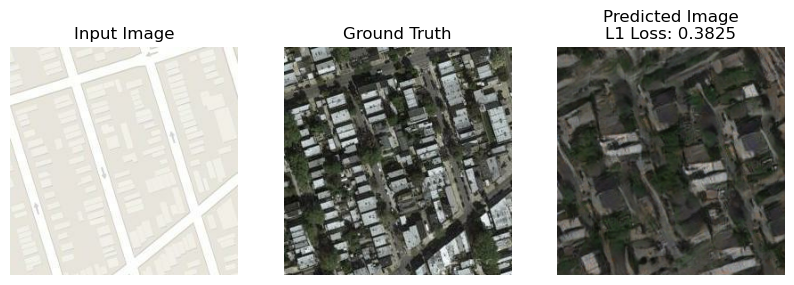

Epoch: 61, Step: 4383, Gen Loss: 24.965049743652344, Disc Loss: 0.4954766631126404756
Epoch: 62, Step: 4383, Gen Loss: 38.29288101196289, Disc Loss: 0.07406523078680038743
Epoch: 63, Step: 4383, Gen Loss: 30.061737060546875, Disc Loss: 0.2288850694894790644
Epoch: 64, Step: 4383, Gen Loss: 36.243526458740234, Disc Loss: 0.05397984385490417553
Epoch: 65, Step: 4383, Gen Loss: 19.686748504638672, Disc Loss: 0.1253119707107544665
Epoch: 66, Step: 4383, Gen Loss: 23.116680145263672, Disc Loss: 0.6177225112915039672
Epoch: 67, Step: 4383, Gen Loss: 26.388294219970703, Disc Loss: 1.5081452131271362723
Epoch: 68, Step: 4383, Gen Loss: 36.073326110839844, Disc Loss: 0.2049001604318618865
Epoch: 69, Step: 4383, Gen Loss: 17.183324813842773, Disc Loss: 0.8074953556060791268
Epoch: 70, Step: 4383, Gen Loss: 31.189716339111328, Disc Loss: 0.1879457682371139555


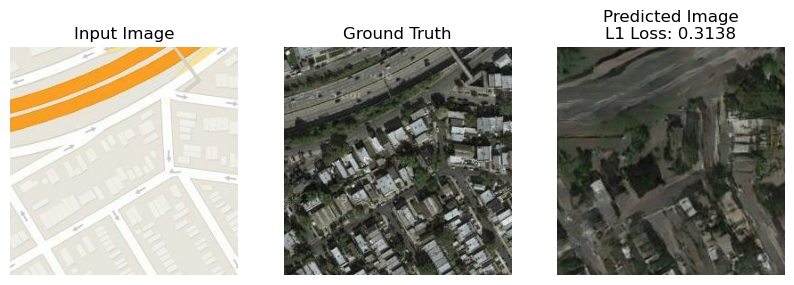

Epoch: 71, Step: 4383, Gen Loss: 11.162732124328613, Disc Loss: 0.6767529249191284965
Epoch: 72, Step: 4383, Gen Loss: 26.325441360473633, Disc Loss: 0.5354294776916504812
Epoch: 73, Step: 4383, Gen Loss: 32.59954833984375, Disc Loss: 0.33498993515968320852
Epoch: 74, Step: 4383, Gen Loss: 7.97976016998291, Disc Loss: 0.288530230522155768765
Epoch: 75, Step: 4383, Gen Loss: 28.852052688598633, Disc Loss: 0.1474192738533020723
Epoch: 76, Step: 4383, Gen Loss: 24.728660583496094, Disc Loss: 1.56447279453277597565
Epoch: 77, Step: 4383, Gen Loss: 37.2442512512207, Disc Loss: 0.04469900205731392264
Epoch: 78, Step: 4383, Gen Loss: 26.829816818237305, Disc Loss: 0.1716057807207107559
Epoch: 79, Step: 4383, Gen Loss: 7.408481597900391, Disc Loss: 0.28476357460021979868
Epoch: 80, Step: 4383, Gen Loss: 8.009042739868164, Disc Loss: 0.76418930292129526555


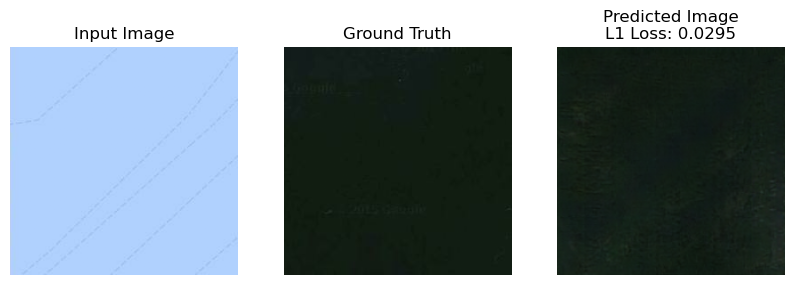

In [16]:
run = wandb.init(config=config, project="pix2pix")

fit(
    train_data=train,
    val_data=val,
    epochs=config["epochs"],
    generator=G,
    discriminator=D,
    generator_optimizer=g_optim,
    discriminator_optimizer=d_optim,
    l1_lambda=config["l1_lambda"],
)

In [17]:
wandb.finish()